In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차를 사용하여 정규화
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# 신경망 정의
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            torch.nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = SimpleNN()

############### Your code here!!!
# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
loss_value = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            loss_value.append((running_loss / 100))
            running_loss = 0.0

print("Finished Training")

# 모델 저장
torch.save(model.state_dict(), 'mnist_simple_nn.pth')


[Epoch 1, Batch 100] Loss: 0.676
[Epoch 1, Batch 200] Loss: 0.269
[Epoch 1, Batch 300] Loss: 0.207
[Epoch 1, Batch 400] Loss: 0.190
[Epoch 1, Batch 500] Loss: 0.158
[Epoch 1, Batch 600] Loss: 0.136
[Epoch 1, Batch 700] Loss: 0.142
[Epoch 1, Batch 800] Loss: 0.125
[Epoch 1, Batch 900] Loss: 0.125
[Epoch 2, Batch 100] Loss: 0.086
[Epoch 2, Batch 200] Loss: 0.092
[Epoch 2, Batch 300] Loss: 0.091
[Epoch 2, Batch 400] Loss: 0.089
[Epoch 2, Batch 500] Loss: 0.095
[Epoch 2, Batch 600] Loss: 0.086
[Epoch 2, Batch 700] Loss: 0.078
[Epoch 2, Batch 800] Loss: 0.092
[Epoch 2, Batch 900] Loss: 0.077
[Epoch 3, Batch 100] Loss: 0.057
[Epoch 3, Batch 200] Loss: 0.061
[Epoch 3, Batch 300] Loss: 0.066
[Epoch 3, Batch 400] Loss: 0.061
[Epoch 3, Batch 500] Loss: 0.058
[Epoch 3, Batch 600] Loss: 0.064
[Epoch 3, Batch 700] Loss: 0.069
[Epoch 3, Batch 800] Loss: 0.056
[Epoch 3, Batch 900] Loss: 0.060
[Epoch 4, Batch 100] Loss: 0.038
[Epoch 4, Batch 200] Loss: 0.042
[Epoch 4, Batch 300] Loss: 0.049
[Epoch 4, 

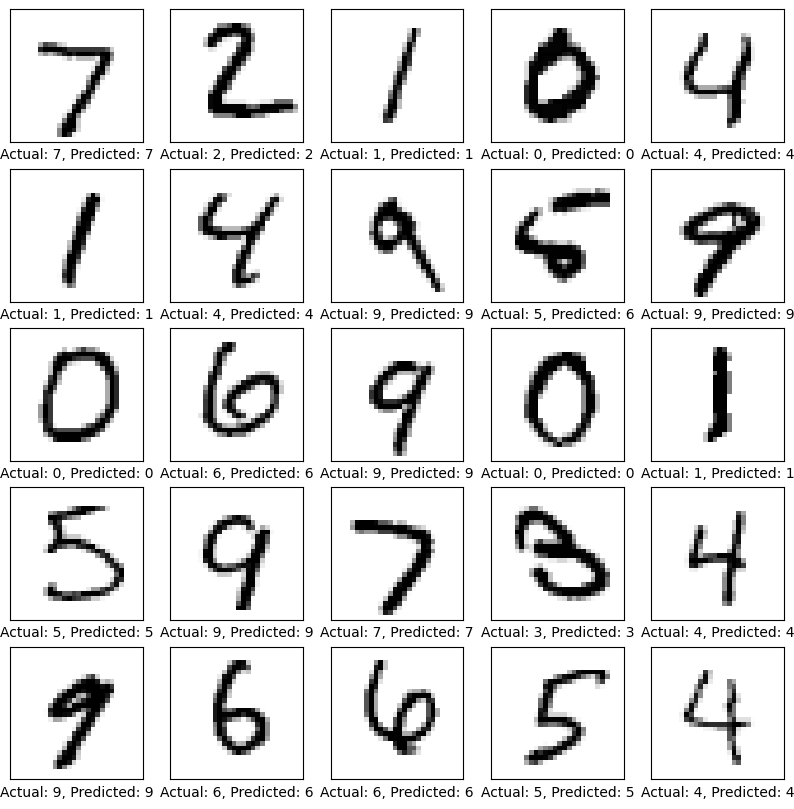

In [3]:
import matplotlib.pyplot as plt

# 학습 완료 후 테스트 데이터로 예측 수행
model.eval()
test_images, test_labels = next(iter(testloader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
with torch.no_grad():
    test_outputs = model(test_images)
softmax = nn.Softmax(dim=1)
probabilities = softmax(test_outputs)
predicted_classes = torch.argmax(probabilities, dim=1)

# 이미지 및 예측 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].cpu().numpy().squeeze(), cmap=plt.cm.binary)
    plt.xlabel(f'Actual: {test_labels[i]}, Predicted: {predicted_classes[i]}')
plt.show()


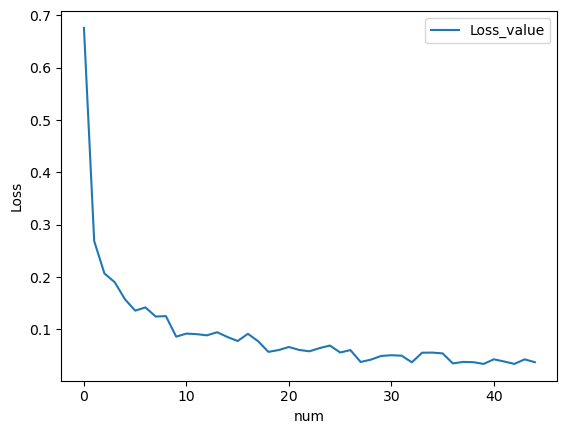

In [11]:
# Plotting the loss values
plt.plot(loss_value, label='Loss_value')
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        X, y = X.to(device), y.to(device)  # 데이터를 디바이스로 이동
        pred = model(X)
        loss = criterion(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # 데이터를 디바이스로 이동
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
# epoch 수만큼 train loop 를 수행하여 반복 학습 합니다.
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, model, criterion, optimizer)
    test_loop(testloader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.041832  [    0/60000]
loss: 0.061690  [ 6400/60000]
loss: 0.030917  [12800/60000]
loss: 0.004421  [19200/60000]
loss: 0.007015  [25600/60000]
loss: 0.069643  [32000/60000]
loss: 0.037169  [38400/60000]
loss: 0.023295  [44800/60000]
loss: 0.036642  [51200/60000]
loss: 0.122479  [57600/60000]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.087425 

Epoch 2
-------------------------------
loss: 0.035945  [    0/60000]
loss: 0.016210  [ 6400/60000]
loss: 0.003213  [12800/60000]
loss: 0.006234  [19200/60000]
loss: 0.000972  [25600/60000]
loss: 0.004572  [32000/60000]
loss: 0.008710  [38400/60000]
loss: 0.003467  [44800/60000]
loss: 0.019434  [51200/60000]
loss: 0.063898  [57600/60000]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.094146 

Epoch 3
-------------------------------
loss: 0.007350  [    0/60000]
loss: 0.008968  [ 6400/60000]
loss: 0.044669  [12800/60000]
loss: 0.003476  [19200/60000]
loss: 0.002445  [25600/60000]
loss: 0.005011  [32000/600